# Coding: Vision Transformers (Oct 14)
## MLP-Mixer (https://arxiv.org/abs/2105.01601)

Mount drive (to store results)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install dependencies

In [2]:
!pip install timm

Imports

In [3]:
import csv
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets,transforms
import torch.utils.tensorboard as tb
import time
from os import path

import shutil
import os

import timm 

from tqdm import tqdm

%pylab inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


Download TinyImageNet dataset

In [4]:
# TinyImageNet
if not path.isdir("./data/tiny-imagenet-200"):
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
    !unzip -q tiny-imagenet-200.zip -d ./data/

In [5]:
#@title Hyperparameters (TODO: find reasonable values)
batch_size = "256" #@param ["64", "128", "256"]
learning_rate = "0.001" #@param ["0.0001", "0.001", "0.01", "0.1"]

Create dataloader for selected dataset; set fitting input/output sizes for selected dataset; set name for log file based on dataset, hyperparameters

In [6]:
dataset = "CIFAR-10" #@param ["STL-10", "TinyImageNet", "CIFAR-10"]

# create datasets
if dataset == "STL-10":
    training_dataset = datasets.STL10(root='./data/STL10', split='train', transform=transforms.ToTensor(), download=True)
    validation_dataset = datasets.STL10(root='./data/STL10', split='test', transform=transforms.ToTensor(), download=True)
    in_size = 96
    num_classes = 10
if dataset == "CIFAR-10":
    training_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=True, download=True, transform=transforms.ToTensor())
    validation_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=False, download=True, transform=transforms.ToTensor())
    in_size = 32
    num_classes = 10
if dataset == "TinyImageNet":
    training_dataset = datasets.ImageFolder("./data/tiny-imagenet-200/train", transform=transforms.Compose([transforms.ToTensor()]))
    validation_dataset = datasets.ImageFolder("./data/tiny-imagenet-200/val", transform=transforms.Compose([transforms.ToTensor()]))
    in_size = 64
    num_classes = 200

# create dataloaders
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=int(batch_size), shuffle=True, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=int(batch_size), shuffle=False, pin_memory=True)

# set name for log file
result_filename = "MLP-Mixer_" + dataset + "_batch" + batch_size + "_learnrate" + learning_rate

Files already downloaded and verified
Files already downloaded and verified


Dataloader Test

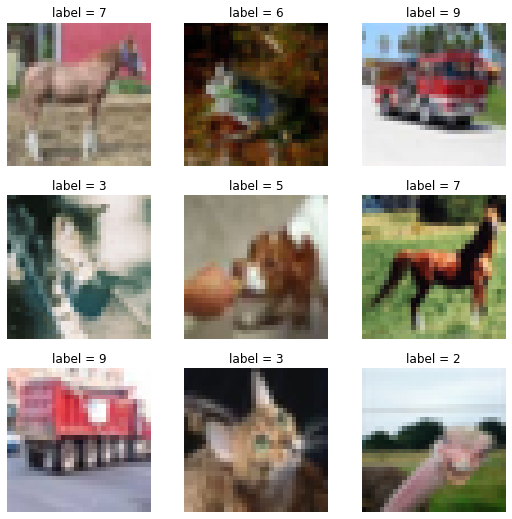

In [7]:
train_data, train_label = next(iter(training_loader))

to_image = transforms.ToPILImage()

figure(figsize=(9,9))
# Plot the first 9 images
for i, (data, label) in enumerate(zip(train_data[:9],train_label[:9])):
    subplot(3,3,1+i)
    imshow(to_image(data))
    title('label = %d'%label)
    axis('off')

Load tensorboard

In [8]:
%load_ext tensorboard
%tensorboard --logdir . --port 6006

Reusing TensorBoard on port 6006 (pid 288), started 2:14:10 ago. (Use '!kill 288' to kill it.)

<IPython.core.display.Javascript object>

Train and log results

In [ ]:
epochs = 2


# create B/16 model
model = timm.models.mlp_mixer.MlpMixer(num_classes=num_classes, img_size=in_size, num_blocks=12, patch_size=16, embed_dim=768).to(device)

'''
Possible parameters:
            num_classes=1000,
            img_size=224,
            in_chans=3,
            patch_size=16,
            num_blocks=8,
            embed_dim=512,
            mlp_ratio=(0.5, 4.0),
            block_layer=MixerBlock,
            mlp_layer=Mlp,
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
            act_layer=nn.GELU,
            drop_rate=0.,
            drop_path_rate=0.,
            nlhb=False,
            stem_norm=False,
'''

# create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(learning_rate))

# create loss function
loss_fn = nn.CrossEntropyLoss()

# create loggers
train_logger = tb.SummaryWriter(path.join(".", 'train{}'.format(time.strftime('%m-%d-%H-%M'))), flush_secs=1)
valid_logger = tb.SummaryWriter(path.join(".", 'valid{}'.format(time.strftime('%m-%d-%H-%M'))), flush_secs=1)

results =  []

global_step = 0

# TODO: once a good number of epochs has been found, do for loop over batch sizes, learning rates; create dataloader, optimizer based on that
# maybe even iterate over datasets
'''
for learning_rate in [0.0001, 0.001, 0.01]:
    for batch_size in [256, 512, 1024]:
        create dataloaders, optimizer
'''

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in tqdm(training_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = loss_fn(outputs, labels) 

        train_logger.add_scalar('loss', loss, global_step)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        global_step += 1

    # validation
    with torch.no_grad(): # No gradient for validation
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)

            val_loss = loss_fn(val_outputs, val_labels)
            
            _, val_preds = torch.max(val_outputs, 1)
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds == val_labels.data).item()
        
    epoch_loss = running_loss/len(training_dataset)
    epoch_acc = running_corrects/ len(training_dataset)

    train_logger.add_scalar('accuracy', epoch_acc, global_step)
    
    val_epoch_loss = val_running_loss/len(validation_dataset)
    val_epoch_acc = val_running_corrects/ len(validation_dataset)
    
    valid_logger.add_scalar('accuracy', val_epoch_acc, global_step)
    
    epoch_results = {
        'Epoch': e,
        'Training Loss': round(epoch_loss, 3),
        'Validation Loss': round(val_epoch_loss, 3),
        'Training Accuracy': round(epoch_acc,3),
        'Validation Accuracy': round(val_epoch_acc,3)
        }
    
    print(epoch_results)
    results.append(epoch_results)

csv_columns = ['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy',  'Validation Accuracy']
try:
    with open(result_filename + ".csv", 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in results:
            writer.writerow(data)
except IOError:
    print("I/O error")

torch.save(model, result_filename + ".th")

# save results to drive
try:
    if not os.path.exists('/content/drive/My Drive/MLP-Mixer_Results/'):
        os.mkdir('/content/drive/My Drive/MLP-Mixer_Results/')
    shutil.copy(result_filename + ".th", "/content/drive/My Drive/MLP-Mixer_Results/" + result_filename + ".th")
    shutil.copy(result_filename + ".csv", "/content/drive/My Drive/MLP-Mixer_Results/" + result_filename + ".csv")
except Exception as e:
    print(e)

  4%|▍         | 8/196 [02:46<1:03:32, 20.28s/it]